## Import Packages

In [1]:
import os
import re
import tqdm
import utils
import torch
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
from torchvision.utils import make_grid, save_image
from solver_utils import get_schedule

plt.rcParams['mathtext.fontset'] = 'cm'
solver_kwargs = {}

In [2]:
def display_image_grid(images, nrows=10):
    image_grid = make_grid(images, nrows, padding=0)
    images_np = (image_grid * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(1, 2, 0).cpu().numpy()
    images = PIL.Image.fromarray(images_np)
    display(images)

def log_gaussian(x, mu, Sigma, t, class_label, mode=None):
    d = x.shape[1]
    full_rank = True if 'full' in mode else False
    if full_rank:
        Sigma_inv = torch.eye(3072).to(device) / (1 + t ** 2)
    else:
        Sigma_inv = torch.inverse(Sigma)
    
    if full_rank:
        L = (1 + t ** 2) ** (0.5) * torch.eye(3072).to(device)
    else:
        L = torch.cholesky(Sigma)
    log_det_Sigma = 2 * torch.sum(torch.log(L.diagonal()))

    log_probs = []
    for k in range(x.shape[0]):
        log_prob = -0.5 * (d * torch.log(torch.tensor(2 * torch.pi)) + log_det_Sigma +
                        (x[k] - mu) @ Sigma_inv @ (x[k] - mu).T)
        log_probs.append(log_prob.unsqueeze(0))
    return torch.cat(log_probs, dim=0)

def softmax_k_logN(x, mu_dict, Sigma_dict, t, mode=None):
    log_probs = []
    for k in range(10):
        Sigma_in = t**2 * torch.eye(3072).to(device) + Sigma_dict[k]
        log_prob = log_gaussian(x, mu_dict[k], Sigma_in, t, k, mode)
        expression = -torch.log(torch.tensor([10]).to(device)) + log_prob
        log_probs.append(log_prob.unsqueeze(1))

    log_probs = torch.cat(log_probs, dim=1)
    w = torch.softmax(log_probs, dim=1)
    return w

@torch.no_grad()
def customized_sampler(
    net, 
    latents,
    cifar10_dataset, 
    class_labels=None, 
    num_steps=None, 
    sigma_min=0.002, 
    sigma_max=80, 
    schedule_type='polynomial', 
    schedule_rho=7, 
    afs=False, 
    denoise_to_zero=False, 
    return_inters=False, 
    t_steps=None,
    mode='low_rank_gaussian',
    **kwargs
):  
    """
    Optimal Euler sampler (generate images from the dataset).

    Args:
        net: A wrapped diffusion model.
        latents: A pytorch tensor. Input sample at time `sigma_max`.
        class_labels: A pytorch tensor. The condition for conditional sampling or guided sampling.
        condition: A pytorch tensor. The condition to the model used in LDM and Stable Diffusion
        unconditional_condition: A pytorch tensor. The unconditional condition to the model used in LDM and Stable Diffusion
        num_steps: A `int`. The total number of the time steps with `num_steps-1` spacings. 
        sigma_min: A `float`. The ending sigma during samping.
        sigma_max: A `float`. The starting sigma during sampling.
        schedule_type: A `str`. The type of time schedule. We support three types:
            - 'polynomial': polynomial time schedule. (Recommended in EDM.)
            - 'logsnr': uniform logSNR time schedule. (Recommended in DPM-Solver for small-resolution datasets.)
            - 'time_uniform': uniform time schedule. (Recommended in DPM-Solver for high-resolution datasets.)
            - 'discrete': time schedule used in LDM. (Recommended when using pre-trained diffusion models from the LDM and Stable Diffusion codebases.)
        schedule_rho: A `float`. Time step exponent. Need to be specified when schedule_type in ['polynomial', 'time_uniform'].
        afs: A `bool`. Whether to use analytical first step (AFS) at the beginning of sampling.
        denoise_to_zero: A `bool`. Whether to denoise the sample to from `sigma_min` to `0` at the end of sampling.
        return_inters: A `bool`. Whether to save intermediate results, i.e. the whole sampling trajectory.
    Returns:
        A pytorch tensor. A batch of generated samples or sampling trajectories if return_inters=True.
    """

    if t_steps is None:
        # Time step discretization.
        t_steps = get_schedule(num_steps, sigma_min, sigma_max, device=latents.device, schedule_type=schedule_type, schedule_rho=schedule_rho, net=net)

    # Main sampling loop.
    x_next = latents * t_steps[0]
    inters_xt = [x_next.unsqueeze(0)]
    x_tmp = x_next.unsqueeze(0)
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):   # 0, ..., N-1
        x_cur = x_next

        # Euler step.
        use_afs = (afs and i == 0)
        if use_afs:
            d_cur = x_cur / ((1 + t_cur**2).sqrt())
        else:
            if mode == 'low_rank_gaussian':
                Lambda_t_cur = Lambda / (t_cur ** 2 + Lambda)
                Lambda_diag = torch.diag(Lambda_t_cur)
                tmp = (U @ Lambda_diag @ U_T.T) @ (x_cur.reshape(-1, shape) - mu).T
                denoised = (mu + tmp.T).reshape(-1, 3, 32, 32)
            elif mode == 'full_rank_gaussian':
                denoised = mu * (t_cur ** 2) / (1 + t_cur ** 2) + x_cur.reshape(-1, shape) / (1 + t_cur ** 2)
                denoised = denoised.reshape(-1, 3, 32, 32)
            elif mode in ['low_rank_mog', 'full_rank_mog']:
                denoised = 0
                w = softmax_k_logN(x_cur.reshape(-1, shape), mu_dict, Sigma_dict, t_cur, mode=mode)
                if mode == 'low_rank_mog':
                    for k in range(10):
                        Lambda_t_cur = Lambda_dict[k] / (t_cur**2 + Lambda_dict[k])
                        Lambda_diag = torch.diag(Lambda_t_cur)
                        tmp = (U_dict[k] @ Lambda_diag @ U_T_dict[k].T) @ (x_cur.reshape(-1, shape) - mu_dict[k]).T
                        denoised += (w[:,k].unsqueeze(1) * (mu_dict[k] + tmp.T)).reshape(-1, 3, 32, 32)
                elif mode == 'full_rank_mog':
                    for k in range(10):
                        denoised += w[:,k].unsqueeze(1) * (mu_dict[k] * (t_cur ** 2) / (1 + t_cur ** 2) + x_cur.reshape(-1, shape) / (1 + t_cur ** 2))
                    denoised = denoised.reshape(-1, 3, 32, 32)

            d_cur = (x_cur - denoised) / t_cur
            
        x_next = x_cur + (t_next - t_cur) * d_cur
        if return_inters:
            inters_xt.append(x_next.unsqueeze(0))
        
    if return_inters:
        return torch.cat(inters_xt, dim=0).to(latents.device)
    return x_next

## Initialization

In [3]:
# Sampling options
solver_kwargs['dataset_name'] = 'cifar10'       # Name of the dataset
solver_kwargs['max_batch_size'] = 100           # Samples to generate
solver_kwargs['solver'] = 'euler'               # Name of the Solver
solver_kwargs['return_inters'] = True           # Whether to return intermediate samples
solver_kwargs['return_denoised'] = True         # Whether to return denoised samples
solver_kwargs['return_eps'] = True              # Whether to return predicted noises
solver_kwargs['afs'] = False
solver_kwargs['denoise_to_zero'] = False

device = torch.device('cuda:0')
seeds = utils.parse_int_list(f"0-{solver_kwargs['max_batch_size']-1}")            # One seed for one image


In [4]:
# Load Dataset
path_to_cifar10 = "/path/to/cifar10-32x32.zip"  # processed cifar10 dataset
cifar10_dataset, labels = utils.cifar10_prepare(path_to_cifar10, device, None, True)

# Load Model
net, solver_kwargs['model_source'] = utils.create_model(dataset_name=solver_kwargs['dataset_name'], device=device)
print('Finished.')


Loading CIFAR-10 dataset...


/zyu/zyu/anaconda3/envs/test/lib/python3.10/site-packages/torch/utils/data/sampler.py:76: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Finished.
Loading the pre-trained diffusion model from "/zyu/zyu/.cache/models/edm-cifar10-32x32-uncond-vp.pkl"...
Finished.


In [17]:
# Configure Solver

solver_kwargs['t_steps'] = None
solver_kwargs['num_steps'] = 1001
solver_kwargs['schedule_type'] = 'polynomial'
solver_kwargs['schedule_rho'] = 1

net.sigma_max = 80
net.sigma_min = 0.002
sampler_fn, solver_kwargs = utils.configure_solver(solver_kwargs, net, device)
t_steps = solver_kwargs['t_steps'].cpu().numpy()


Solver settings:
	dataset_name: cifar10
	max_batch_size: 100
	solver: euler
	afs: False
	denoise_to_zero: False
	model_source: edm
	t_steps: tensor([8.0000e+01, 7.9920e+01, 7.9840e+01,  ..., 1.6199e-01, 8.1993e-02,
        1.9989e-03], device='cuda:0')
	num_steps: 1001
	schedule_type: polynomial
	schedule_rho: 1
	sigma_min: 0.002
	sigma_max: 80
	nfe: 1000


## Setting Mode and Sampling
<!-- See Section xx in our JSTAT paper for more details: **Geometric Regularity in Deterministic Sampling of Diffusion-based Generative Models** (https://arxiv.org/abs/2506.10177) -->

In [26]:
# 'sampling': sampling with scores predicted by the diffusion model
# 'low_rank_gaussian': sampling with scores approximated by low rank Gaussian
# 'full_rank_gaussian': sampling with scores approximated by full rank Gaussian
# 'low_rank_mog': sampling with scores approximated by low rank mixture of Gaussians
# 'full_rank_mog': sampling with scores approximated by full rank mixture of Gaussians

modes = ['sampling', 'low_rank_gaussian', 'full_rank_gaussian', 'low_rank_mog', 'full_rank_mog']
mode = modes[0]

shape = 3 * 32 * 32
dataset = cifar10_dataset.reshape(-1, shape)
mu = torch.mean(dataset, dim=0)
Sigma = torch.cov(dataset.T)

if mode == 'low_rank_gaussian':
    num_pcs = 1000
    U, Lambda, U_T = torch.pca_lowrank(Sigma, q=num_pcs)
    Lambda_diag = torch.diag(Lambda)
elif mode in ['low_rank_mog', 'full_rank_mog']:
    # Extract images from each class
    cifar10_dataset_cond = [None for _ in range(10)]
    for i in range(10):
        lab = [0 for _ in range(10)]
        lab[i] = 1
        label_to_select = torch.tensor(lab, dtype=torch.bool)
        mask = (labels == label_to_select).all(dim=1)
        images_sel = cifar10_dataset[mask]
        cifar10_dataset_cond[i] = images_sel
    # Approximate the distribution of images in each class by mixture of Gaussians
    mu_dict, Sigma_dict, U_dict, Lambda_dict, U_T_dict = {}, {}, {}, {}, {}
    for i in range(10):
        dataset = cifar10_dataset_cond[i].reshape(-1, shape)
        mu_dict[i] = torch.mean(dataset, dim=0)
        if mode == 'low_rank_mog':
            Sigma_dict[i] = torch.cov(dataset.T)
            num_pcs = 1000
            U_dict[i], Lambda_dict[i], U_T_dict[i] = torch.pca_lowrank(Sigma_dict[i], q=num_pcs)
        elif mode == 'full_rank_mog':
            Sigma_dict[i] = torch.eye(3072).to(device)

In [27]:
# Loop over batches.
num_batches = ((len(seeds) - 1) // (solver_kwargs['max_batch_size']) + 1)
all_batches = torch.as_tensor(seeds).tensor_split(num_batches)
rank_batches = all_batches
print(f'Generating {len(seeds)} samples...')
for batch_seeds in tqdm.tqdm(rank_batches, unit='batch'):
    batch_size = len(batch_seeds)
    if batch_size == 0:
        continue

    # Pick latents and labels.
    rnd = utils.StackedRandomGenerator(device, batch_seeds)
    latents = rnd.randn([batch_size, net.img_channels, net.img_resolution, net.img_resolution], device=device)
    class_labels = None
    if net.label_dim:
        class_labels = torch.eye(net.label_dim, device=device)[rnd.randint(net.label_dim, size=[batch_size], device=device)]

    # Generate images.
    with torch.no_grad():
        if mode == 'sampling':
            inter_xt, _, _ = sampler_fn(net, latents, class_labels=class_labels, **solver_kwargs)
        else:
            inter_xt = customized_sampler(net, latents, cifar10_dataset, mode=mode, **solver_kwargs)
        images = inter_xt[-1]
print(f'Finished.')


Generating 100 samples...


100%|██████████| 1/1 [01:41<00:00, 101.18s/batch]

Finished.


Samples generated with mode: low_rank_gaussian


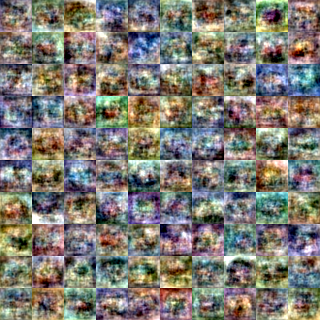

In [20]:
if mode != 'sampling':
    print('Samples generated with mode:', mode)
    display_image_grid(images, nrows=10)

Images generated by diffusion sampling:


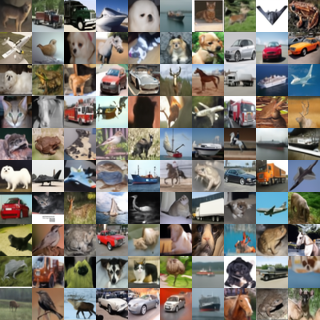

In [28]:
if mode == 'sampling':
    print('Images generated by diffusion sampling:')
    display_image_grid(images, nrows=10)

# Regularity of Sampling Trajectories
See Section 3.2 in our JSTAT paper for more details: **Geometric Regularity in Deterministic Sampling of Diffusion-based Generative Models** (https://arxiv.org/abs/2506.10177)

  0%|          | 0/100 [00:00<?, ?item/s]

100%|██████████| 100/100 [00:02<00:00, 33.41item/s]


Raw trajectories


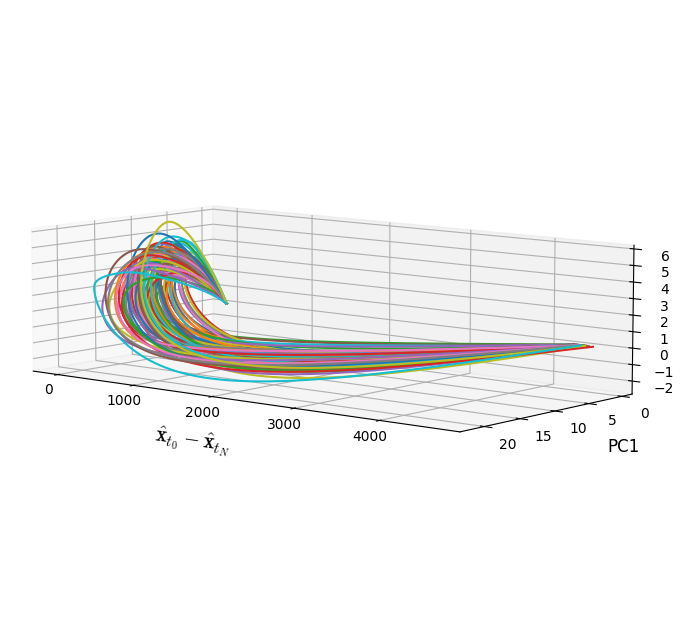

In [42]:
# Regularity

seed = 0
torch.manual_seed(seed)
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

traj = inter_xt             # shape: (num_steps, bs, ch, r, r)
ch, res = net.img_channels, net.img_resolution
shape = ch * res * res

# Initialize (shape-1) random vectors to be orthogonalized
ws = torch.rand((shape-1, shape), device=device)

# The first basis
x_0, x_T = traj[-1], traj[0]
v = (x_0 - x_T).reshape(batch_size, -1)
v = v / torch.norm(v, p=2, dim=(1)).unsqueeze(1)

# Loop over every trajectory
for b in tqdm.tqdm(range(traj.shape[1]), unit='item'):
    data = traj[:,b].reshape(-1, shape)

    # Generate (shape-1) vectors perpendicular to v
    vectors = ws - v[b].unsqueeze(0).repeat(shape-1,1) * torch.matmul(v[b], ws.transpose(0,1)).unsqueeze(1)
    
    # Schmidt orthogonalization
    ortho_vectors, _ = torch.linalg.qr(vectors.t())
    ortho_vectors = ortho_vectors.t()

    # Project trajectory to the (shape-1)-dim subspace
    data_proj = torch.matmul(torch.matmul(data, ortho_vectors.transpose(0, 1)).unsqueeze(1), ortho_vectors.unsqueeze(0)).squeeze()
    
    U, S, V = torch.pca_lowrank(data_proj, q=100)              # PCA
    # print(torch.cumsum(S**2, dim=0) / (S**2).sum())   # PCA ratio

    v1, v2, v3 = v[b], V[:,0], V[:,1]   # The first basis + top 2 principle components
    # Schmidt orthogonalization
    u1 = v1
    u2 = v2 - (torch.sum(u1 * v2) / torch.sum(u1 * u1)) * u1
    u3 = v3 - (torch.sum(u1 * v3) / torch.sum(u1 * u1)) * u1 - (torch.sum(u2 * v3) / torch.sum(u2 * u2)) * u2
    u2 = u2 / torch.norm(u2, p=2)
    u3 = u3 / torch.norm(u3, p=2)

    # Flip the basis for better visualization
    tensor_in_test = data[(data.shape[0]//2)] - x_0[b].reshape(-1, shape)
    u1 = u1 if torch.sum(tensor_in_test * u1) < 0 else -u1
    u2 = u2 if torch.sum(tensor_in_test * u2) > 0 else -u2
    u3 = u3 if torch.sum(tensor_in_test * u3) > 0 else -u3
    u3 *= -1

    # Compute the 3D coordinates
    tensor = data - x_0[b].reshape(-1, shape)   # Align the end of trajectories to the origin
    xs = torch.sum(tensor * u1, dim=1).unsqueeze(1) if b == 0 else torch.cat((xs, torch.sum(tensor * u1, dim=1).unsqueeze(1)), dim=1)
    ys = torch.sum(tensor * u2, dim=1).unsqueeze(1) if b == 0 else torch.cat((ys, torch.sum(tensor * u2, dim=1).unsqueeze(1)), dim=1)
    zs = torch.sum(tensor * u3, dim=1).unsqueeze(1) if b == 0 else torch.cat((zs, torch.sum(tensor * u3, dim=1).unsqueeze(1)), dim=1)

# Drop (1-ratio_to_keep) outliers (in terms of the L2 norm of PC dimensions) for better visualization
ratio_to_keep = 0.8
pc_norm = (ys ** 2 + 10 * zs ** 2).sum(dim=0)
num_to_keep = int(traj.shape[1] * ratio_to_keep)
sorted_indices = torch.argsort(pc_norm)
start_index = (traj.shape[1] - num_to_keep) // 2
end_index = start_index + num_to_keep
indices_to_keep = sorted_indices[start_index:end_index]

xs = xs[:,indices_to_keep].cpu().numpy()
ys = ys[:,indices_to_keep].cpu().numpy()
zs = zs[:,indices_to_keep].cpu().numpy()
for b in range(xs.shape[1]):
    ax.plot3D(xs[:,b], ys[:,b], zs[:,b])


# Visualization
xticks = plt.xticks()[0][1:-1]
new_xticks = [int(-1 * tick) for tick in xticks]
plt.xticks(xticks, new_xticks)
fontsize = 12
ax.set_xlabel(r'${\hat{\bf{x}}}_{t_0} - {\hat{\bf{x}}}_{t_N}$', fontsize=fontsize+3, labelpad=30)
ax.set_ylabel('PC1', fontsize=fontsize, labelpad=15)
ax.set_zlabel('PC2', fontsize=fontsize, labelpad=8)

ax.view_init(elev=8, azim=130)
ax.set_box_aspect([3,1.5,0.8])

print('Raw trajectories')
plt.show()

xs_ori, ys_ori, zs_ori = xs, ys, zs

# Calibrated Trajectories 
Rotate for better visualization! See Section 3.2 in our JSTAT paper for more details: **Geometric Regularity in Deterministic Sampling of Diffusion-based Generative Models** (https://arxiv.org/abs/2506.10177)

100%|██████████| 80/80 [00:00<00:00, 942.28item/s]


Aligned trajectories


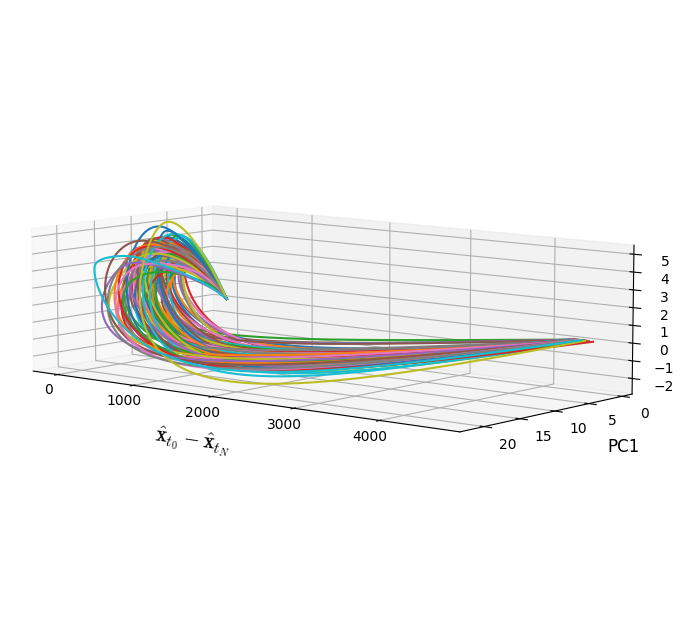

In [43]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

seed = 42
torch.manual_seed(seed)

# Rotate to minimize the distance between each trajectory with the chosen reference trajectory
num_steps = solver_kwargs['num_steps']
base_idx = 0
B = np.array([xs[:,base_idx], ys[:,base_idx], zs[:,base_idx]]).T
B_2d = B[:,1:]

proj_dim = 2
for i in tqdm.tqdm(range(xs_ori.shape[1]), unit='item'):
    A = np.array([xs[:,i], ys[:,i], zs[:,i]]).T
    A_2d = A[:,1:]
    ATB = A.T.dot(B) if proj_dim == 3 else A_2d.T.dot(B_2d) 
    
    U, S, V = np.linalg.svd(ATB)
    O = U.dot(V.T)

    if proj_dim == 3:
        rotated_traj = A.dot(O)
        xs1 = rotated_traj[:,0]
        ys1 = rotated_traj[:,1]
        zs1 = rotated_traj[:,2]
    elif proj_dim == 2:
        rotated_traj = A_2d.dot(O)
        xs1 = A[:,0]
        ys1 = rotated_traj[:,0]
        zs1 = rotated_traj[:,1]

    ax.plot3D(xs1, ys1, zs1)

fontsize = 12
ax.set_xlabel(r'${\hat{\bf{x}}}_{t_0} - {\hat{\bf{x}}}_{t_N}$', fontsize=15, labelpad=30)
ax.set_ylabel('PC1', fontsize=fontsize, labelpad=15)
ax.set_zlabel('PC2', fontsize=fontsize, labelpad=8)

xticks = plt.xticks()[0][1:-1]
new_xticks = [int(-1 * tick) for tick in xticks]
plt.xticks(xticks, new_xticks)

if mode == 'full_rank_gaussian':
    ax.set_ylim(-1.2,1.2)
    ax.set_zlim(-1.2,1.2)
    ax.set_yticks([-1, -0.5, 0, 0.5, 1])
    ax.set_zticks([-1, -0.5, 0, 0.5, 1])

ax.view_init(elev=8, azim=130)
ax.set_box_aspect([3,1.5,0.8])

# f = plt.gcf()
# f.savefig(os.path.join("./", f"traj_3d_{mode}.png"), dpi=200)
# f.clear()

print('Aligned trajectories')
plt.show()

# Curvature and Torsion 
Compute curvature and torsion. See Section 3.3 in our JSTAT paper for more details: **Geometric Regularity in Deterministic Sampling of Diffusion-based Generative Models** (https://arxiv.org/abs/2506.10177)

In [44]:
# Compute arc length
data = np.concatenate((xs[:, np.newaxis], ys[:, np.newaxis], zs[:, np.newaxis]), axis=1)  # (num_steps, 3, batch)
residual_data = data[1:] - data[:-1]         # (num_steps-1, 3, batch)
ds = np.linalg.norm(residual_data, axis=1)   # (num_steps-1, batch)
tmp = np.concatenate((np.zeros((1, ds.shape[1])), ds), axis=0)
s = np.cumsum(tmp, axis=0)                   # (num_steps, batch)   approximated arc length

def cal_curv_tors(xs, ys, zs, s, window_size):
    half_size = window_size // 2
    
    full_size = xs.shape[0]
    a1, a2, a3, a4, a5, a6 = [np.zeros((full_size, xs.shape[1])) for k in range(6)]
    b_x1, b_x2, b_x3, b_y1, b_y2, b_y3, b_z1, b_z2, b_z3 = [np.zeros((full_size, xs.shape[1])) for k in range(9)]
    
    s_new = np.concatenate([s[half_size+1:2*half_size+1], s, s[-2*half_size:-half_size]])
    xs_new = np.concatenate([xs[half_size+1:2*half_size+1], xs, xs[-2*half_size:-half_size]])
    ys_new = np.concatenate([ys[half_size+1:2*half_size+1], ys, ys[-2*half_size:-half_size]])
    zs_new = np.concatenate([zs[half_size+1:2*half_size+1], zs, zs[-2*half_size:-half_size]])
    for i in range(window_size):
        s_offset = s_new[i:] if i == window_size - 1 else s_new[i:-2*half_size+i]
        x_offset = xs_new[i:] if i == window_size - 1 else xs_new[i:-2*half_size+i]
        y_offset = ys_new[i:] if i == window_size - 1 else ys_new[i:-2*half_size+i]
        z_offset = zs_new[i:] if i == window_size - 1 else zs_new[i:-2*half_size+i]
        s_res = s_offset - s
        
        weight = 1
        a1 += weight * (s_res ** 2)
        a2 += weight * (s_res ** 3) / 2
        a3 += weight * (s_res ** 4) / 4
        a4 += weight * (s_res ** 4) / 6
        a5 += weight * (s_res ** 5) / 12
        a6 += weight * (s_res ** 6) / 36
        b_x1 += weight * s_res * (x_offset - xs_new[half_size:-half_size])
        b_y1 += weight * s_res * (y_offset - ys_new[half_size:-half_size])
        b_z1 += weight * s_res * (z_offset - zs_new[half_size:-half_size])
        b_x2 += weight * s_res ** 2 * (x_offset - xs_new[half_size:-half_size]) / 2
        b_y2 += weight * s_res ** 2 * (y_offset - ys_new[half_size:-half_size]) / 2
        b_z2 += weight * s_res ** 2 * (z_offset - zs_new[half_size:-half_size]) / 2
        b_x3 += weight * s_res ** 3 * (x_offset - xs_new[half_size:-half_size]) / 6
        b_y3 += weight * s_res ** 3 * (y_offset - ys_new[half_size:-half_size]) / 6
        b_z3 += weight * s_res ** 3 * (z_offset - zs_new[half_size:-half_size]) / 6
    
    As = np.array([[a1, a2, a4], [a2, a3, a5], [a4, a5, a6]])
    Bs = np.array([[b_x1, b_y1, b_z1], [b_x2, b_y2, b_z2], [b_x3, b_y3, b_z3]])
    
    As_inv = np.linalg.inv(As.transpose(2,3,0,1)).transpose(2,3,0,1)
    As_inv = As_inv.reshape(3,3,-1).transpose(2,0,1)
    Bs = Bs.reshape(3,3,-1).transpose(2,0,1)
    Xs = np.matmul(As_inv, Bs).transpose(1,2,0).reshape(3,3,-1,xs.shape[1])
    
    r_p = np.concatenate((Xs[0,0][:, np.newaxis], Xs[0,1][:, np.newaxis], Xs[0,2][:, np.newaxis]), axis=1)      # (num_steps-2*half_size, 3, batch)
    r_pp = np.concatenate((Xs[1,0][:, np.newaxis], Xs[1,1][:, np.newaxis], Xs[1,2][:, np.newaxis]), axis=1)     # (num_steps-2*half_size, 3, batch)
    r_ppp = np.concatenate((Xs[2,0][:, np.newaxis], Xs[2,1][:, np.newaxis], Xs[2,2][:, np.newaxis]), axis=1)    # (num_steps-2*half_size, 3, batch)
    
    cross = np.cross(r_p.transpose((2,0,1)), r_pp.transpose((2,0,1))).transpose(1,2,0)
    curvatures = np.linalg.norm(cross, axis=1) / np.linalg.norm(r_p, axis=1)**3
    torsions = (np.sum(cross*r_ppp, axis=1)) / np.linalg.norm(cross, axis=1)**2
    
    return curvatures, torsions


In [45]:
# Calculate curvature and torsion
window_size = 101
half_size = (window_size - 1) // 2
curvatures, torsions = cal_curv_tors(xs, ys, zs, s, window_size=window_size)

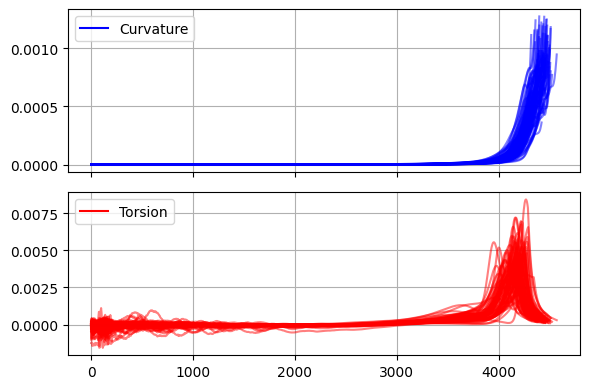

In [46]:
# Visualization
fig, axs = plt.subplots(2, figsize=(6, 4))

for i in range(curvatures.shape[1]):
    axs[0].plot(s[:curvatures.shape[0],i], curvatures[:,i], color='blue', alpha=0.5)  # Curvature
    axs[1].plot(s[:torsions.shape[0],i], torsions[:,i], color='red', alpha=0.5)     # Torsion

fontsize = 10
axs[0].grid()
axs[1].grid()
axs[0].set_xticklabels([])
axs[0].plot([0, 0], [0, 0], color='blue', label='Curvature')
axs[1].plot([0, 0], [0, 0], color='red', label='Torsion')
axs[0].legend()
axs[1].legend()

plt.tight_layout()
plt.show()